In [13]:
import glob
import re

import numpy as np
import pandas as pd
import tqdm
import itertools
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
# pd.options.display.max_columns = 2000

<ipython-input-13-d205f42a1420>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [14]:
class IteratorLogs():

    def __init__(self, logfile) -> None:
        with open(logfile) as f:
            self.lines = f.readlines()
        self.index = 0

    def next(self):
        temp = self.next_line()
        # filter GLOG
        while temp.find('.h:') != -1 or temp.find('.cc:') != -1:
            temp = self.next_line()
        # print(self.index, temp)
        return temp

    def next_line(self):
        if self.index == len(self.lines):
            raise StopIteration()
        temp = self.lines[self.index]
        self.index += 1
        return temp


# run_log_file to [{ts: ts1, k1: v, k2: v}, (ts2, {})]
def parse_log(logfile, ):
    iter_log = IteratorLogs(logfile)

    dic = defaultdict(lambda: [])

    proc_num = -1
    perf_counter_names = set()
    
    
    while True:
        try:
            each_line = iter_log.next()
            each_line = each_line.strip()
            r = re.search(r'\[proc (\d)\] (\d+) steps, (total:.*$)', each_line)
            if r:
                proc = int(r[1])
                proc_num = max(proc_num,  proc)
                step = int(r[2])
                items = r[3].split(", ")
                items = [(each.split(": ")[0], each.split(": ")[1]) for each in items]
                for each_k, each_v in items:
                    dic[f'proc{proc}_{each_k}'].append(float(each_v))
                    perf_counter_names.add(each_k)
                continue
            
        except StopIteration:
            # if 'ts' in dic.keys():
            #     results.append(dic)
            break
    
    # 对每个proc 取倒数三个
    for each_k, each_v in list(dic.items()):
        dic[f"{each_k}_jicha"] = max(each_v[-3:]) - min(each_v[-3:])
        dic[each_k] = np.mean(each_v[-3:])

    
    # 对所有的proc的每一项，取均值，与极差
    ret_dict = dict()
    proc_num = proc_num+1
    for name in perf_counter_names:
        items = [dic[f'proc{proc}_{name}'] for proc in range(proc_num)]
        ret_dict[f'{name}_mean'] = np.mean(items)
        ret_dict[f'{name}_jicha'] = np.max(items) - np.min(items)
    
    return ret_dict

In [15]:
parse_log("../benchmark/log/exp0-single-3090/run_0/log")

{'backward_mean': 23.468333333333334,
 'backward_jicha': 0.0,
 'sample_mean': 1.529,
 'sample_jicha': 0.0,
 'total_mean': 36.25633333333334,
 'total_jicha': 0.0,
 'update_mean': 3.254,
 'update_jicha': 0.0,
 'forward_mean': 7.997,
 'forward_jicha': 0.0}

In [16]:
def parse_logs_to_df(exp_dir):
    df = pd.DataFrame()
    if exp_dir.find("run_") == -1:
        log_files = glob.glob(f"{exp_dir}/*")
    else:
        log_files = glob.glob(f"{exp_dir}")
        
    run_dfs = []
        
    for run_path in tqdm.tqdm(log_files):
        run_id = run_path.split("/")[-1]
        logfile = glob.glob(f'{run_path}/log')
        assert len(logfile) == 1
        logfile = logfile[0]
        config_file = f'{run_path}/config'

        run_df = parse_log(logfile,)
        run_df["run_id"] = run_id
        import json
        with open(config_file, "r") as f:
            config_dict = json.load(f)

        for each_k, each_v in config_dict.items():
            run_df[each_k] = each_v

        for each_k in list(run_df.keys()):
            run_df[each_k] = [run_df[each_k]]

        run_df = pd.DataFrame.from_dict(run_df)
        run_dfs.append(run_df)
        
    df = pd.concat(run_dfs, axis=0,  ignore_index=True)
    # df = df.append(run_df, ignore_index=True)
    for each in ['max_step', 'no_save_emb', 'log_interval']:
        if each in df.keys():
            del df[each]
    # df = df.astype({k: int for k in int_columns})
    return df


In [17]:
def TidyQueryStr(query_string):
    # query_string = query_string.replace('false', '"false"')
    # query_string = query_string.replace('true', '"true"')
    return query_string


def QueryStr(kv_pair):
    kEQvList = []
    for k, v in kv_pair:
        if type(v) is str:
            kEQvList.append(f'`{k}` == "{v}"')
        else:
            kEQvList.append(f'`{k}` == {v}')
        # kEQvList.append(f'`{k}` == {v}')
    return ' and '.join(kEQvList)


def DecoupleAnalysis(df, for_variables, line_variables, x_variable,
                     y_variable, sort_variable,
                     mark_variable=None, legend_loc = 'in'):
    if type(for_variables) is not list:
        for_variables = [for_variables]
    if type(line_variables) is not list:
        line_variables = [line_variables]

    if type(y_variable) is not list:
        y_variable = [y_variable]

    if type(x_variable) is not str:
        raise Exception("current only support one x variable")

    # for each graph
    for each_graph_specified in itertools.product(*[df[_].unique() for _ in for_variables]):
        kv_pair = list(zip(for_variables, each_graph_specified))
        graph_query_string = QueryStr(kv_pair)
        # graph_query_string = ' and '.join([f'{k}=={v}' for k,v in kv_pair])
        # graph_query_string = ' and '.join([f'{k}=={"\"" + v +"\"" if type(v) is str else v}' for k,v in kv_pair])
        graph_query_string = TidyQueryStr(graph_query_string)
        # display("graph_query_string", graph_query_string)

        sub_df = df.query(graph_query_string)

        plt.figure(figsize=(10, 5))
        plt.title(f'{kv_pair}')
        # for each line
        for each_line_specified in itertools.product(*[sub_df[_].unique() for _ in line_variables]):
            line_specified_kv_pair = list(
                zip(line_variables, each_line_specified))
            # convert string to "string" for query

            # for each in range(len(line_specified_kv_pair)):
            # 	if type(line_specified_kv_pair[each][1]) == str:
            # 		line_specified_kv_pair[each] =  (line_specified_kv_pair[each][0], f'"{line_specified_kv_pair[each][1]}"')

            # line_query_string = ' and '.join([f'{k}=={v}' for k,v in line_specified_kv_pair])
            line_query_string = QueryStr(line_specified_kv_pair)
            line_query_string = TidyQueryStr(line_query_string)
            # display(line_query_string)
            subsub_df = sub_df.query(line_query_string)

            # 避免画两组数据在一根线上
            if len(subsub_df[sort_variable].unique()) != len(subsub_df):
                display(subsub_df)
                subsub_df.to_csv("fordebug.csv")
                raise Exception(f"len(subsub_df[sort_variable].unique()) != len(subsub_df)"
                                f"({len(subsub_df[sort_variable].unique())} vs {len(subsub_df)})"
                                )

            for each_y_variable in y_variable:
                if mark_variable is None:
                    other_variables = (subsub_df['run_id'],)
                else:
                    # other_variables = (subsub_df['run_id'], subsub_df[mark_variable])
                    other_variables = (subsub_df[mark_variable], )
                xy_pairs = sorted(zip(subsub_df[x_variable], subsub_df[each_y_variable],
                                  *other_variables, subsub_df[sort_variable]), key=lambda x: x[-1])
                x = [each[0] for each in xy_pairs]
                y = [each[1] for each in xy_pairs]
                z = [each[2:-1] for each in xy_pairs]

                if len(x) != 0:
                    plt.plot(
                        x, y, label=f"{line_specified_kv_pair}_{each_y_variable}")

                if mark_variable is not None:
                    for each_x, each_y, each_z in zip(x, y, z):
                        plt.annotate(f'{each_z}', (each_x, each_y), )

        plt.xlabel(x_variable)
        plt.ylabel(str(y_variable))
        if legend_loc == 'in':
            plt.legend()
        else:
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()

        # break


## exp0 DGL_KE: 3090 v.s. A30

100%|██████████| 8/8 [00:00<00:00, 687.49it/s]


,nr_gpus,throughput,dataset,gpu_type,run_id
0,0,27.581388,FB15k,3090,run_0
1,1,144.557413,FB15k,3090,run_1
2,2,147.775972,FB15k,3090,run_2
3,3,211.071068,FB15k,3090,run_3
4,4,273.449739,FB15k,3090,run_4
5,5,333.548287,FB15k,3090,run_5
6,6,397.532355,FB15k,3090,run_6
7,7,457.643107,FB15k,3090,run_7
8,8,529.268259,FB15k,3090,run_8
18,2,163.692912,FB15k,a30,run_2


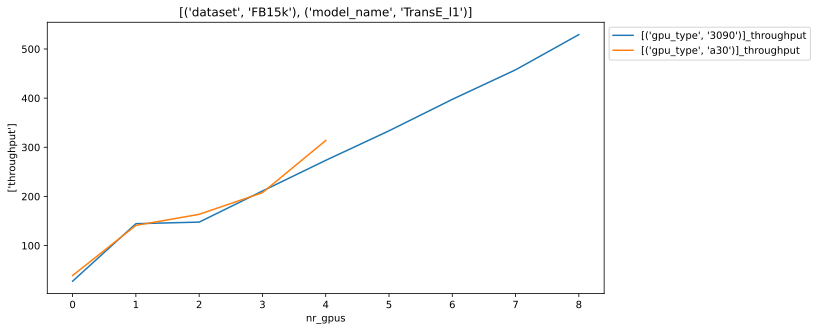

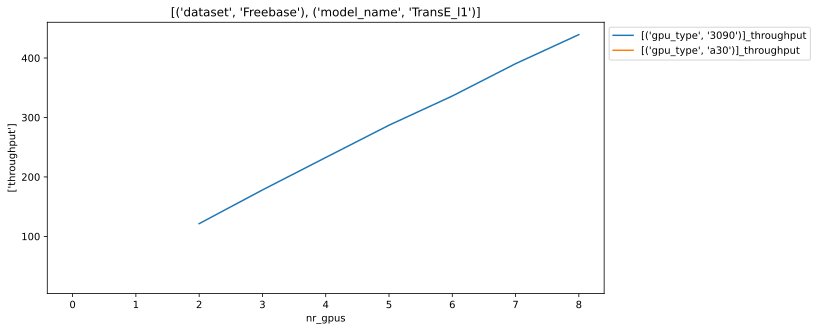

In [20]:
df_3090 = parse_logs_to_df("../benchmark/log/exp0-single-3090")
df_3090['gpu_type'] = "3090"
df_a30 = parse_logs_to_df("../benchmark/log/exp0-single-A30")
df_a30['gpu_type'] = "a30"


df = pd.concat([df_3090, df_a30], axis=0, ignore_index=True)

df['nr_procs'] =  df['nr_gpus'].apply(lambda x: max(1, x))
df['throughput'] = df['nr_procs'] * 1000 / df['total_mean']

query_df = df
query_df = df[df['dataset'] == "FB15k"]
display(query_df[['nr_gpus','throughput', 'dataset', "gpu_type", "run_id"]])

DecoupleAnalysis(df, 
for_variables = ['dataset', 'model_name'], 
line_variables = ['gpu_type',], 
x_variable = 'nr_gpus', 
# y_variable = ['throughput',],
y_variable = ['throughput',],

sort_variable = 'nr_gpus',
# mark_variable= 'ts',
legend_loc='out'
)